# ReadMe
- This section is to learn about how to predict churn through logistic regression
- it will use sklearn data

# Environment Set Up
- install necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
pd.options.display.float_format = "{:,.2f}".format
from datasets import load_dataset

c:\Users\asus\anaconda3\envs\david\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data
- we will use this telco churn dataset credited here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [28]:
df = pd.read_csv("hf://datasets/scikit-learn/churn-prediction/dataset.csv")
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


# 1. EDA and Data Preprocessing

In [29]:
#check dataframe size
df.shape

(7043, 21)

In [30]:
# Check Dataset Types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [31]:
# check empty columns
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [32]:
# Get object column unique value, Limit for <10 unique values
object_cols=[col for col in df.columns if df[col].dtype == 'object']
for i in object_cols:
    if len(df[i].unique())<=10:
        print(i, ":", df[i].unique())
    else:
        print(i, " has too many unique values of " + str(len(df[i].unique())) )

customerID  has too many unique values of 7043
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges  has too many unique values of 6531
Churn : ['No' 'Yes']


In [33]:
# as we want to create a prediction model, we will have to do following changes
# 1. Change total charges to float
df['TotalCharges']=(df['TotalCharges']).replace(r'\s+', np.nan, regex=True)
df['TotalCharges']=df['TotalCharges'].astype(float)
# 2. Create dummy variable for categorical
dummy_var=(df[object_cols]).drop(columns=['customerID','TotalCharges'])
dummy_columns=[col for col in dummy_var.columns]

for col in dummy_columns:
    dummy_temp=pd.get_dummies(df[col],drop_first=True,prefix='Dummy '+col,dtype='int')
    df=pd.concat([df,dummy_temp],axis=1)



df=df.drop(columns=dummy_columns)
df.head()


,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Dummy gender_Male,Dummy Partner_Yes,Dummy Dependents_Yes,Dummy PhoneService_Yes,Dummy MultipleLines_No phone service,...,Dummy StreamingTV_Yes,Dummy StreamingMovies_No internet service,Dummy StreamingMovies_Yes,Dummy Contract_One year,Dummy Contract_Two year,Dummy PaperlessBilling_Yes,Dummy PaymentMethod_Credit card (automatic),Dummy PaymentMethod_Electronic check,Dummy PaymentMethod_Mailed check,Dummy Churn_Yes
0,7590-VHVEG,0,1,29.85,29.85,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,0,34,56.95,"1,889.50",1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,0,2,53.85,108.15,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,0,45,42.30,"1,840.75",1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


# 2. Logistic Regression
-now we can move to logistic regression

In [41]:
#set customer ID as index so we do not lose it
df=df.set_index('customerID')
#define Y and X, Y is churn, and we use rest of variable for X
X=df.drop(columns=['Dummy Churn_Yes'])
Y=df['Dummy Churn_Yes']

In [46]:
#create function to split test and train, then do standard scaler transformation
def data_split_and_scale(X, Y, test_size=0.3, random_state=42):
    '''
    UDF to split data into train and test then scale the data, default value of test_size and random_state are 0.3 and 42 respectively
    '''
    X=X.fillna(0)
    X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=test_size, random_state=random_state)

    #Only scale non boolean
    non_boolean_cols=X.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    X_train[non_boolean_cols] = scaler.fit_transform(X_train[non_boolean_cols])
    X_test[non_boolean_cols] = scaler.transform(X_test[non_boolean_cols])

    return X_train, X_test, y_train, y_test

In [47]:
def logistic_regression_creation(X_train, X_test, y_train, y_test):
    '''
    UDF to create and evaluate logistic regression with train test split data as input
    '''
    #model creation
    model=LogisticRegression()
    model.fit(X_train, y_train)

    #model prediction
    predictions=model.predict(X_test)
    
    #model evaluation
    model_accuracy_score=accuracy_score(y_test, predictions)
    model_classification_report=classification_report(y_test,predictions)
    model_confusion_matrix=confusion_matrix(y_test, predictions)

    #feature importance/coefficient
    coeff_df= pd.DataFrame(model.coef_.T, X.columns, columns=['Coefficient']).sort_values('Coefficient',ascending=False, key=abs)
    
    return model, model_accuracy_score, model_classification_report, model_confusion_matrix, coeff_df

In [48]:
def visualize_evaluation(accuracy_score, classification_report, confusion_matrix, coefficient_df):
    '''
    UDF to visualize the evaluation of logistic regression
    '''
    #accuracy score
    print('\033[1m Accuracy Score of The Model is: \033[0m', np.round(accuracy_score,3), '\n')
    #classification report
    print('Classification Report: \033[0m \n', classification_report)
    #confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix,
                annot=True,
                fmt="d",
                cmap=ListedColormap(["#377eb8", "#999999", "#377eb8", "#999999"]),
                cbar=False
               )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()
    #coefficient df
    display(coefficient_df)


In [49]:
#preprocess data
X_train, X_test, y_train, y_test = data_split_and_scale(X, Y, test_size=0.3, random_state=42)
#build model
model, accuracy_score_value, classif_report, conf_matrix, coeff_df = logistic_regression_creation(X_train, X_test, y_train, y_test)

 Accuracy Score of The Model is:  0.813 

Classification Report:  
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1539
           1       0.69      0.57      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.81      0.81      0.81      2113



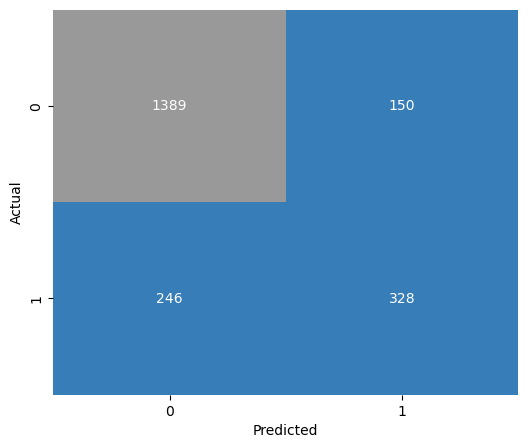

,Coefficient
Dummy Contract_Two year,-1.46
tenure,-1.33
Dummy InternetService_Fiber optic,0.95
TotalCharges,0.63
Dummy Contract_One year,-0.60
Dummy PhoneService_Yes,-0.47
Dummy OnlineSecurity_Yes,-0.41
Dummy StreamingMovies_Yes,0.38
Dummy PaymentMethod_Electronic check,0.33
Dummy PaperlessBilling_Yes,0.31


In [51]:
# visualize model
visualize_evaluation(accuracy_score_value, classif_report, conf_matrix, coeff_df)

now we see we have 81% accuracy for this prediction